In [4]:
# Imports
import re
import cv2
import os
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import shutil
import random
from tqdm.notebook import tqdm
from urllib import request
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
os.chdir("/Users/emmettsexton/Dropbox/Mac (2)/Desktop/BSE/Trimester 3/03 DL Images/02 Project/")

'/Users/emmettsexton/Dropbox/Mac (2)/Desktop/BSE/Trimester 3/03 DL Images/02 Project'

# Load train, validation, and test images plus their labels
Then create dataframes for each to be used in the image generators below

In [8]:
# Load the file paths for all available images from the competition
train_paths = list(paths.list_images("./00 Data/train")) 
val_paths = list(paths.list_images("./00 Data/val")) 
test_paths = list(paths.list_images("./00 Data/test")) 

# Print the number of images in each set
print(f"Training set size: {len(train_paths)}")
print(f"Validation set size: {len(val_paths)}")
print(f"Test set size: {len(test_paths)}")

Training set size: 11541
Validation set size: 2473
Test set size: 2474


In [9]:
# Load labels for all images
labels = pd.read_csv('./00 Data/train_labels.csv')

# Load all image paths
all_image_paths = list(paths.list_images("./00 Data"))

# Extract the ID from each image file path
def extract_id(file_path):
    base_name = os.path.basename(file_path)
    file_id, _ = os.path.splitext(base_name)
    return file_id

# Create a DataFrame from the image paths
image_data = {
    'file_path': all_image_paths,
    'id': [extract_id(path) for path in all_image_paths]
}
image_df = pd.DataFrame(image_data)

# Merge the image paths with the labels
merged_df = pd.merge(image_df, labels, on='id', how='inner')

In [10]:
# Split merged_df into training, validation, and test DataFrames
train_df = merged_df[merged_df['file_path'].isin(train_paths)]
val_df = merged_df[merged_df['file_path'].isin(val_paths)]
test_df = merged_df[merged_df['file_path'].isin(test_paths)]

# Create train, validation, and test image generators
Only augmenting the training images

In [11]:
# Define the data generator for training with augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)
# Define the ImageDataGenerator for validation and test (without augmentations)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Specify the columns for the generator
image_column = 'file_path'
label_columns = labels.columns[1:]  # all columns except 'id' are labels

# Create training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col=image_column,
    y_col=label_columns.tolist(),
    target_size=(128, 128), 
    batch_size=32,
    class_mode='raw',
    shuffle=True
)

# Create validation generator
validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col=image_column,
    y_col=label_columns.tolist(),
    target_size=(128, 128),
    batch_size=32,
    class_mode='raw',
    shuffle=True
)

# Create test generator
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col=image_column,
    y_col=label_columns.tolist(),
    target_size=(128, 128),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

Found 11541 validated image filenames.
Found 2473 validated image filenames.
Found 2474 validated image filenames.


# Define and fit our preferred model

In [53]:
# Define the EarlyStopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    
    patience=20,           
    verbose=1,             
    restore_best_weights=True  
)

# Fit model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(128, 128, 3), kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(len(label_columns), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=300,
    callbacks=[early_stopping_callback]
)

# Save the entire model
model.save('./01 Models/final_model.keras')

Epoch 1/300


2024-06-26 09:46:06.767783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - ETA: 0s - loss: 1.8576 - accuracy: 0.3126

2024-06-26 09:47:22.057151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 80s 213ms/step - loss: 1.8576 - accuracy: 0.3126 - val_loss: 2.0430 - val_accuracy: 0.1852
Epoch 2/300
361/361 [==============================] - 72s 198ms/step - loss: 1.6135 - accuracy: 0.3816 - val_loss: 1.6647 - val_accuracy: 0.3599
Epoch 3/300
361/361 [==============================] - 75s 206ms/step - loss: 1.5175 - accuracy: 0.4216 - val_loss: 1.6953 - val_accuracy: 0.3352
Epoch 4/300
361/361 [==============================] - 78s 214ms/step - loss: 1.4516 - accuracy: 0.4467 - val_loss: 1.4631 - val_accuracy: 0.4561
Epoch 5/300
361/361 [==============================] - 83s 229ms/step - loss: 1.3914 - accuracy: 0.4766 - val_loss: 1.5734 - val_accuracy: 0.3688
Epoch 6/300
361/361 [==============================] - 88s 241ms/step - loss: 1.3346 - accuracy: 0.5007 - val_loss: 1.7381 - val_accuracy: 0.3963
Epoch 7/300
361/361 [==============================] - 93s 258ms/step - loss: 1.2976 - accuracy: 0.5193 - val_loss: 1.6885 - val_accurac

2024-06-26 17:38:44.935939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 6s 65ms/step
Classification Report:
                  precision    recall  f1-score   support

 antelope_duiker       0.59      0.69      0.64       357
            bird       0.90      0.89      0.90       227
           blank       0.58      0.50      0.54       323
     civet_genet       0.90      0.95      0.92       380
             hog       0.95      0.85      0.90       142
         leopard       0.94      0.89      0.92       336
monkey_prosimian       0.83      0.83      0.83       401
          rodent       0.84      0.82      0.83       308

        accuracy                           0.80      2474
       macro avg       0.82      0.81      0.81      2474
    weighted avg       0.80      0.80      0.80      2474



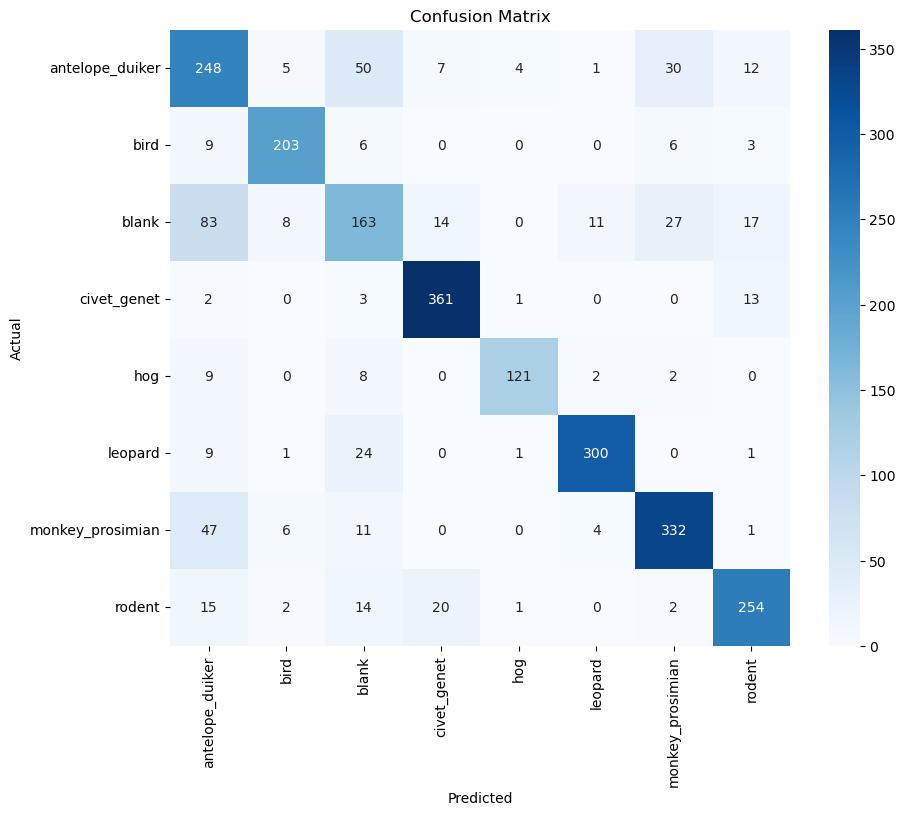

Overall Accuracy: 0.8011


In [61]:
# Predict on the test set
y_pred = model.predict(test_generator)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = np.argmax(test_generator.labels, axis=1)

class_names = label_columns

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print overall accuracy
accuracy = np.sum(y_pred_classes == y_true) / len(y_true)
print(f"Overall Accuracy: {accuracy:.4f}")